# Product Amount Forecast by Time

## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

## Indest Data

In [5]:
df = pd.read_csv("Frozen_Dessert_Production.csv",index_col='DATE',
                 parse_dates=True)

In [6]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


## Exploratory Data Analysis and Visualization

1. Implement basic steps to see how is your data looks like
2. Change the column name as "Production"
2. Plot your data and see its seasonalty

In [8]:
df.columns = ['Production']
df

,Production
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
...,...
2019-05-01,114.561
2019-06-01,124.960
2019-07-01,110.263


<AxesSubplot:xlabel='DATE'>

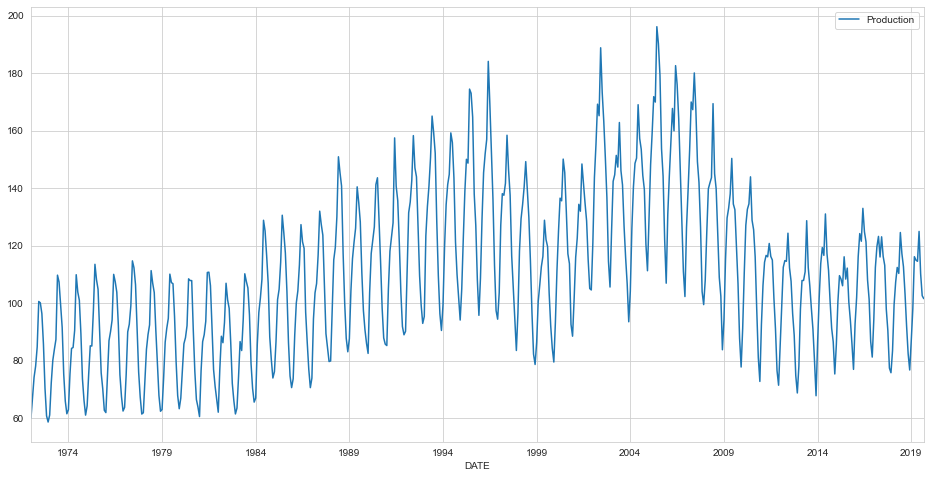

In [9]:
df.plot(figsize=(16,8))

## Preprocessing of Data

### Train Test Split

In [10]:
len(df)

573

In [11]:
test_size = 24

In [12]:
test_ind = len(df)- test_size
test_ind

549

In [13]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [14]:
test

,Production
DATE,
2017-10-01,90.473
2017-11-01,77.438
2017-12-01,75.812
2018-01-01,83.434
2018-02-01,99.490
2018-03-01,107.315
2018-04-01,112.431
2018-05-01,110.354
2018-06-01,124.584


### Scaling

In [15]:
from sklearn.preprocessing import MinMaxScaler

In [16]:
scaler = MinMaxScaler()

In [17]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [18]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [19]:
length = 12
batch_size = 1
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = batch_size)

In [20]:
len(generator)

537

In [21]:
generator[0]

(array([[[0.00947104],
         [0.06108982],
         [0.11326273],
         [0.14145625],
         [0.18982663],
         [0.30495972],
         [0.30154406],
         [0.27416065],
         [0.19736841],
         [0.08532665],
         [0.01561588],
         [0.        ]]]),
 array([[0.01774221]]))

In [22]:
X, y = generator[0]

In [23]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.00947104 0.06108982 0.11326273 0.14145625 0.18982663 0.30495972
 0.30154406 0.27416065 0.19736841 0.08532665 0.01561588 0.        ]
Predict this y: 
 [[0.01774221]]


## Modelling & Model Performance

### Import related libraries

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [26]:
n_features = train_scaled.shape[1]
n_features

1

### Creating Model

### with "tanh" activation function

In [27]:
model = Sequential()
model.add(LSTM(100, activation = 'tanh', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(50, activation = 'tanh'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [29]:
from tensorflow.keras.callbacks import EarlyStopping

In [30]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5)

In [31]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = batch_size)

In [32]:
len(validation_generator)

12

In [33]:
model.fit_generator(generator,
                    epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/20
537/537 [==============================] - 18s 18ms/step - loss: 0.0183 - val_loss: 0.0028
Epoch 2/20
537/537 [==============================] - 8s 14ms/step - loss: 0.0048 - val_loss: 0.0021
Epoch 3/20
537/537 [==============================] - 8s 14ms/step - loss: 0.0044 - val_loss: 0.0026
Epoch 4/20
537/537 [==============================] - 7s 14ms/step - loss: 0.0041 - val_loss: 0.0019
Epoch 5/20
537/537 [==============================] - 7s 14ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 6/20
537/537 [==============================] - 8s 14ms/step - loss: 0.0035 - val_loss: 0.0029
Epoch 7/20
537/537 [==============================] - 7s 14ms/step - loss: 0.0035 - val_loss: 0.0021
Epoch 8/20
537/537 [==============================] - 7s 14ms/step - loss: 0.0031 - val_loss: 0.0022
Epoch 9/20
537/537 [==============================] - 8s 14ms/step - loss: 0.0034 - val_loss: 0.0040


<AxesSubplot:>

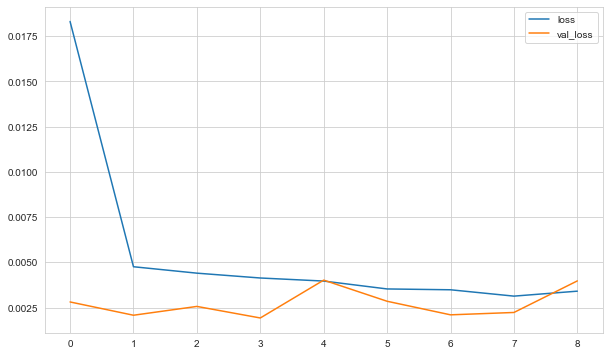

In [34]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

#### Evaluate on Test Data

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [36]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

In [37]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

In [38]:
predictions_scaled

[array([0.20171899], dtype=float32),
 array([0.15099147], dtype=float32),
 array([0.15027983], dtype=float32),
 array([0.18643358], dtype=float32),
 array([0.23285893], dtype=float32),
 array([0.2724602], dtype=float32),
 array([0.30022243], dtype=float32),
 array([0.31323665], dtype=float32),
 array([0.30985638], dtype=float32),
 array([0.28090763], dtype=float32),
 array([0.22915158], dtype=float32),
 array([0.16162711], dtype=float32)]

In [39]:
eval_metrics(test_scaled[:length], predictions_scaled)

r2_score: 0.14589254951499342 
mae: 0.08467017865276356 
mse: 0.01065126550594788 
rmse: 0.10320496841697051


#### Inverse Transformations and Comparing

In [40]:
predictions = scaler.inverse_transform(predictions_scaled)

In [41]:
compare = test[:12]

In [42]:
compare['Predictions'] = predictions

In [43]:
compare

,Production,Predictions
DATE,,
2017-10-01,90.473,86.399
2017-11-01,77.438,79.423
2017-12-01,75.812,79.325
2018-01-01,83.434,84.297
2018-02-01,99.490,90.681
2018-03-01,107.315,96.127
2018-04-01,112.431,99.945
2018-05-01,110.354,101.734
2018-06-01,124.584,101.269


<AxesSubplot:xlabel='DATE'>

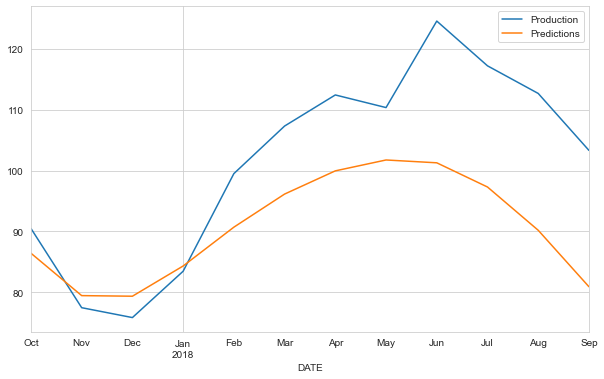

In [44]:
compare.plot()

In [46]:
eval_metrics(compare.Production, compare.Predictions)

r2_score: 0.14589254951499298 
mae: 11.643326480238267 
mse: 201.41620499215477 
rmse: 14.192117706394447


#### Calculation R2 Score and Error Metrics

### with "relu" activation function

In [47]:
model = Sequential()
model.add(LSTM(100, activation = 'relu', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(50, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [48]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 12, 100)           40800     
                                                                 
 lstm_3 (LSTM)               (None, 50)                30200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [49]:
model.fit_generator(generator,
                    epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/20
537/537 [==============================] - 11s 12ms/step - loss: 0.0270 - val_loss: 0.0064
Epoch 2/20
537/537 [==============================] - 6s 12ms/step - loss: 0.0091 - val_loss: 0.0041
Epoch 3/20
537/537 [==============================] - 6s 11ms/step - loss: 0.0068 - val_loss: 0.0019
Epoch 4/20
537/537 [==============================] - 6s 12ms/step - loss: 0.0061 - val_loss: 0.0021
Epoch 5/20
537/537 [==============================] - 6s 11ms/step - loss: 0.0052 - val_loss: 0.0044
Epoch 6/20
537/537 [==============================] - 6s 11ms/step - loss: 0.0053 - val_loss: 0.0022
Epoch 7/20
537/537 [==============================] - 6s 12ms/step - loss: 0.0048 - val_loss: 0.0054
Epoch 8/20
537/537 [==============================] - 7s 14ms/step - loss: 0.0040 - val_loss: 0.0016
Epoch 9/20
537/537 [==============================] - 7s 12ms/step - loss: 0.0038 - val_loss: 0.0020
Epoch 10/20
537/537 [==============================] - 6s 12ms/step - loss: 0.0035 - val_l

<AxesSubplot:>

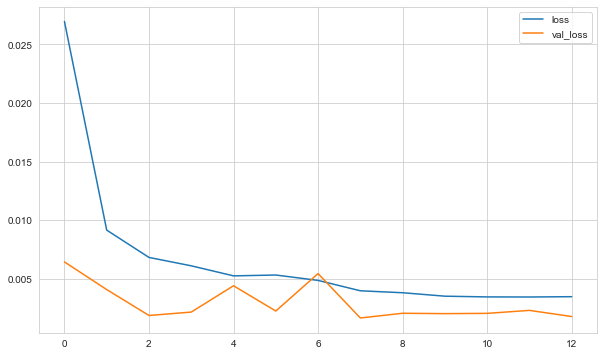

In [50]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

#### Evaluate on Test Data

In [51]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

In [52]:
eval_metrics(test_scaled[:length], predictions_scaled)

r2_score: 0.5150815845798682 
mae: 0.062110959334989 
mse: 0.006047242403084532 
rmse: 0.07776401740576763


In [53]:
predictions_relu = scaler.inverse_transform(predictions_scaled)

In [54]:
compare_relu = test[:12]

In [55]:
compare['Predictions_relu'] = predictions_relu

In [57]:
compare

,Production,Predictions,Predictions_relu
DATE,,,
2017-10-01,90.473,86.399,96.979
2017-11-01,77.438,79.423,92.126
2017-12-01,75.812,79.325,93.398
2018-01-01,83.434,84.297,102.426
2018-02-01,99.490,90.681,110.636
2018-03-01,107.315,96.127,116.463
2018-04-01,112.431,99.945,120.621
2018-05-01,110.354,101.734,123.089
2018-06-01,124.584,101.269,123.699


<AxesSubplot:xlabel='DATE'>

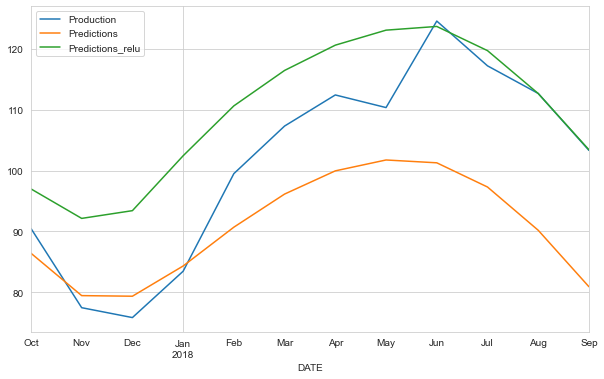

In [58]:
compare.plot()

#### Inverse Transformations and Comparing

#### Calculation R2 Score and Error Metrics

In [59]:
eval_metrics(compare.Production, compare.Predictions_relu)

r2_score: 0.5150815845798693 
mae: 8.541120250895736 
mse: 114.35379343579022 
rmse: 10.693633313134981


## Retrain and Forecasting

Select activation function providing a better score, create your final model with full data, forecast for the next 12 months, and plot this forecast.

In [60]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [61]:
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = batch_size)

In [62]:
len(df)

573

In [63]:
len(generator)

561

In [64]:
model = Sequential()
model.add(LSTM(100, activation = 'relu', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(50, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs=15)

Epoch 1/15
561/561 [==============================] - 11s 12ms/step - loss: 0.0254
Epoch 2/15
561/561 [==============================] - 6s 11ms/step - loss: 0.0100
Epoch 3/15
561/561 [==============================] - 6s 11ms/step - loss: 0.0065
Epoch 4/15
561/561 [==============================] - 7s 12ms/step - loss: 0.0056
Epoch 5/15
561/561 [==============================] - 8s 14ms/step - loss: 0.0060
Epoch 6/15
561/561 [==============================] - 7s 12ms/step - loss: 0.0053
Epoch 7/15
561/561 [==============================] - 6s 12ms/step - loss: 0.0052
Epoch 8/15
561/561 [==============================] - 6s 12ms/step - loss: 0.0048
Epoch 9/15
561/561 [==============================] - 6s 11ms/step - loss: 0.0039
Epoch 10/15
561/561 [==============================] - 7s 12ms/step - loss: 0.0034
Epoch 11/15
561/561 [==============================] - 6s 11ms/step - loss: 0.0034
Epoch 12/15
561/561 [==============================] - 6s 11ms/step - loss: 0.0031
Epoch 13/15


In [65]:
scaled_full_data.shape

(573, 1)

In [66]:
scaled_full_data[-length:].shape

(12, 1)

In [67]:
forecast = []
# Replace periods with whatever forecast length you want

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)
    
    # store prediction
    forecast.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis = 1)

In [68]:
forecast = scaler.inverse_transform(forecast)

In [69]:
forecast

array([[ 88.4035642 ],
       [ 81.67646541],
       [ 80.67806809],
       [ 90.29180688],
       [104.34626453],
       [115.1908586 ],
       [121.12706798],
       [125.80715647],
       [125.53230023],
       [117.38400781],
       [107.46288921],
       [ 96.44122686]])

In [70]:
df

,Production
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
...,...
2019-05-01,114.561
2019-06-01,124.960
2019-07-01,110.263


In [71]:
forecast_index = pd.date_range(start = '2019-10-01', periods = length, freq = 'MS')

In [72]:
forecast_index

DatetimeIndex(['2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01'],
              dtype='datetime64[ns]', freq='MS')

In [73]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

In [74]:
forecast_df

,Forecast
2019-10-01,88.404
2019-11-01,81.676
2019-12-01,80.678
2020-01-01,90.292
2020-02-01,104.346
2020-03-01,115.191
2020-04-01,121.127
2020-05-01,125.807
2020-06-01,125.532
2020-07-01,117.384


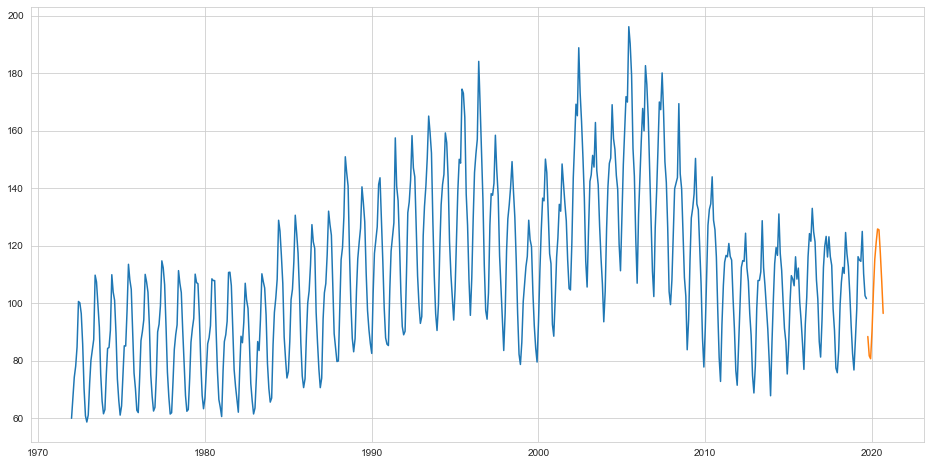

In [76]:
plt.figure(figsize = (16, 8))
plt.plot(df.index, df['Production'])
plt.plot(forecast_df.index, forecast_df['Forecast'])

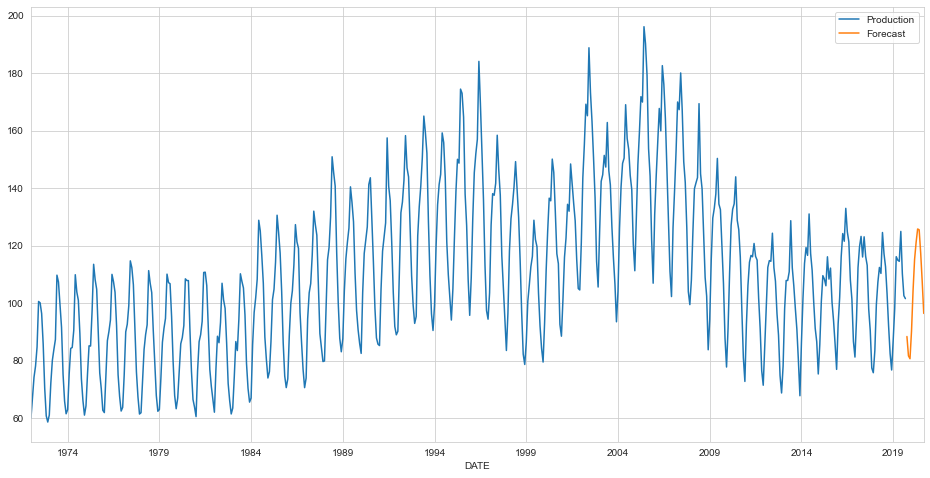

In [77]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

(576.0, 608.0)

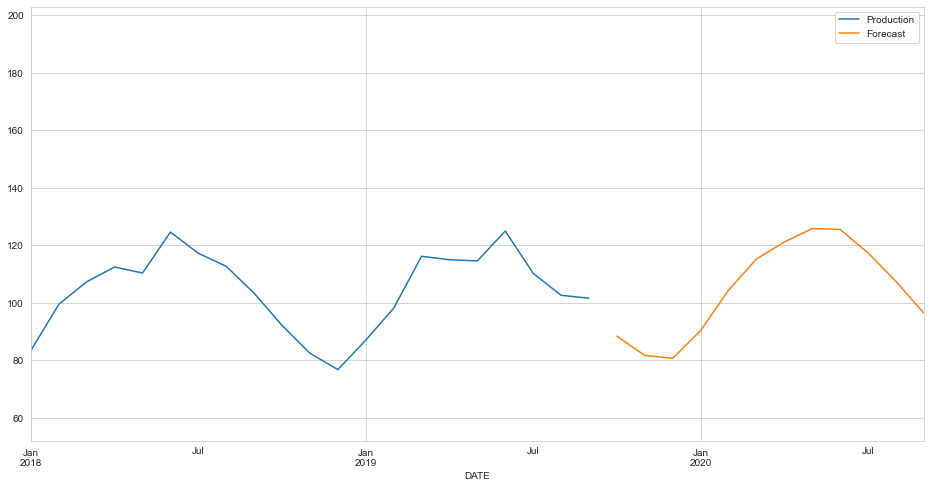

In [78]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2018-01-01', '2020-09-01')